## Self-Organizing Maps for Clustering

In [1]:
# Install if necessary
# pip install minisom

In [63]:
import numpy as np
import pandas as pd
import matplotlib as plt
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [64]:
clean_df = pd.read_csv('cleaned_df.csv')

In [86]:
clean_df.head()

,Card Identifier,Transaction Date,Transaction Time,Risk Assessment,Payment Method,Transaction Value,Merchant Location,Card Present Status,Chip Usage,Cross-border Transaction (Yes/No),Acquiring Institution ID,Merchant Identifier,Merchant Category Code (MCC),Fraud Indicator (Yes/No),Year,Month,Day,Hour,Merchant Category
0,card 1,2023-05-11,16:22:14.0,362.0,Paypass - Contactless,13.98,USA,CP,Yes,No,acquirer 1,merchant 1,5812.0,No,2023,5,11,0,Eating places and Restaurants
1,card 2,2023-06-05,15:16:35.0,602.0,Online,24.64,USA,CNP,No,No,acquirer 2,merchant 2,4121.0,No,2023,6,5,0,Taxicabs and Limousines
2,card 3,2023-06-05,11:57:40.0,482.0,Unknown,15.00,USA,CNP,No,No,acquirer 3,merchant 3,7211.0,No,2023,6,5,0,Laundry – Family and Commercial
3,card 4,2023-07-20,18:26:30.0,947.0,Online,30.56,USA,CNP,No,No,acquirer 1,merchant 4,5814.0,No,2023,7,20,0,Fast Food Restaurants
4,card 5,2023-03-03,19:03:11.0,1382.0,Magnetic Stripe,50.85,USA,CP,No,No,acquirer 4,merchant 1,5812.0,No,2023,3,3,0,Eating places and Restaurants


In [90]:
# Debugging: works
clean_df[clean_df['Fraud Indicator (Yes/No)'] == 'Yes'].head(5)

,Card Identifier,Transaction Date,Transaction Time,Risk Assessment,Payment Method,Transaction Value,Merchant Location,Card Present Status,Chip Usage,Cross-border Transaction (Yes/No),Acquiring Institution ID,Merchant Identifier,Merchant Category Code (MCC),Fraud Indicator (Yes/No),Year,Month,Day,Hour,Merchant Category
41,card 867,2023-11-03,19:58:47.0,4227.0,Paypass - Contactless,25.42,FRA,CP,Yes,Yes,acquirer 52,merchant 126,763.0,Yes,2023,11,3,0,Agricultural Co-operatives
278,card 1596,2023-02-10,12:05:17.0,1842.0,Magnetic Stripe,97.68,ITA,CP,No,Yes,acquirer 366,merchant 8,7011.0,Yes,2023,2,10,0,"Lodging – Hotels, Motels, Resorts, Central Res..."
1079,card 606,2023-05-31,14:07:49.0,467.0,Magnetic Stripe,24.96,USA,CP,No,No,acquirer 218,merchant 1,5812.0,Yes,2023,5,31,0,Eating places and Restaurants
1486,card 2407,2023-08-13,21:09:09.0,1737.0,Magnetic Stripe,109.05,USA,CP,No,No,acquirer 55,merchant 1,5812.0,Yes,2023,8,13,0,Eating places and Restaurants
2131,card 2570,2023-08-09,14:46:24.0,2792.0,Chip,117.98,USA,CP,No,No,acquirer 45,merchant 816,5661.0,Yes,2023,8,9,0,Shoe Stores


### Data Preprocessing

In [91]:
clean_df_preprocessed = clean_df.copy()
clean_df_preprocessed = clean_df_preprocessed.drop(columns=['Card Identifier', 'Transaction Date', 'Transaction Time', 'Year', 'Month', 'Day', 'Hour'])

#### Label Encoding Categorical Variables

In [92]:
# Initialize a label encoder for each categorical column
label_encoders = {}
categorical_columns = ['Payment Method', 'Merchant Location', 'Card Present Status', 'Chip Usage', 'Cross-border Transaction (Yes/No)', 'Acquiring Institution ID', 'Merchant Identifier', 'Merchant Category']
for col in categorical_columns:
    le = LabelEncoder()
    clean_df_preprocessed[col] = le.fit_transform(clean_df_preprocessed[col])
    label_encoders[col] = le  # Storing the label encoder if you need to inverse transform later

# Convert 'Fraud Indicator (Yes/No)' to binary
clean_df_preprocessed['Fraud Indicator (Yes/No)'] = clean_df_preprocessed['Fraud Indicator (Yes/No)'].apply(lambda x: 1 if x == 'Yes' else 0)

In [68]:
clean_df_preprocessed.head(10)

,Risk Assessment,Payment Method,Transaction Value,Merchant Location,Card Present Status,Chip Usage,Cross-border Transaction (Yes/No),Acquiring Institution ID,Merchant Identifier,Merchant Category Code (MCC),Fraud Indicator (Yes/No),Merchant Category
0,362.0,5,13.98,127,1,1,0,0,0,5812.0,0,134
1,602.0,3,24.64,127,0,0,0,382,1108,4121.0,0,331
2,482.0,10,15.00,127,0,0,0,489,1877,7211.0,0,208
3,947.0,3,30.56,127,0,0,0,0,1988,5814.0,0,148
4,1382.0,1,50.85,127,1,0,0,594,0,5812.0,0,134
5,612.0,5,75.77,127,1,1,0,698,0,5812.0,0,134
6,1327.0,3,0.00,127,0,0,0,798,2099,5816.0,0,110
7,1037.0,8,2.99,127,0,0,0,798,2099,5816.0,0,110
8,497.0,3,30.00,127,0,0,0,382,2210,8398.0,0,70
9,1297.0,5,11.44,127,1,1,0,898,2321,5499.0,0,232


In [94]:
# Debugging: works
clean_df_preprocessed[clean_df_preprocessed['Fraud Indicator (Yes/No)'] == 1].head(5)

,Risk Assessment,Payment Method,Transaction Value,Merchant Location,Card Present Status,Chip Usage,Cross-border Transaction (Yes/No),Acquiring Institution ID,Merchant Identifier,Merchant Category Code (MCC),Fraud Indicator (Yes/No),Merchant Category
41,4227.0,5,25.42,44,1,1,1,717,289,763.0,1,16
278,1842.0,1,97.68,66,1,0,1,558,2431,7011.0,1,213
1079,467.0,1,24.96,127,1,0,0,403,0,5812.0,1,134
1486,1737.0,1,109.05,127,1,0,0,746,0,5812.0,1,134
2131,2792.0,0,117.98,127,1,0,0,646,2450,5661.0,1,310


#### SMOTE Upsampling

In [69]:
# TO-DO

#### Initialize and Train SOM

In [99]:
X = clean_df_preprocessed.drop(['Fraud Indicator (Yes/No)'], axis=1).values    # Exclude the target variable

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Initialize and train the SOM
som_size = int(np.sqrt(5 * np.sqrt(X.shape[0]))) # Trained based on num of samples in X 
som = MiniSom(som_size, som_size, X.shape[1], sigma=0.5, learning_rate=0.5)
som.train_random(X_scaled, 1000) 

In [135]:
y = clean_df_preprocessed['Fraud Indicator (Yes/No)']                          # Convert target to binary

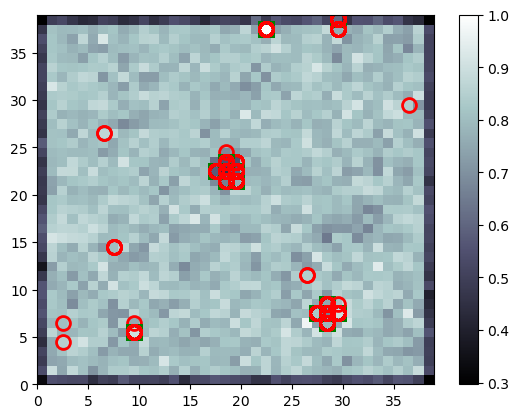

In [100]:
# Plotting the SOM (considering U-matrix visualization)
from pylab import bone, pcolor, colorbar, show
bone()
pcolor(som.distance_map().T)  # Distance map as background
colorbar()

markers = ['s', 'o']          # Markers for fraud (1) and non-fraud (0)
colors = ['g', 'r']
for i, x in enumerate(X_scaled):
    w = som.winner(x)         # Getting the winner node
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor=colors[y[i]],
         markerfacecolor='None',
         markersize=10,
         markeredgewidth=2)
show()

The red circles represent clusters that exhibit a high percentage of fraudulence transactions.

In [179]:
# Get the mappings of samples to neurons
win_map = som.win_map(X_scaled)

In [180]:
from collections import defaultdict

# Create a dictionary to hold indices for each neuron
neuron_indices = defaultdict(list)

# For each data point in X_scaled, find its best matching unit (BMU) and record the index
for idx, data_point in enumerate(X_scaled):
    winner = som.winner(data_point)
    neuron_indices[winner].append(idx)

# Now neuron_indices holds the indices of X_scaled associated with each neuron

In [181]:
fraud_rates = {}

y_binary = clean_df_preprocessed['Fraud Indicator (Yes/No)'].values  # Assuming this is aligned with X_scaled

for neuron, indices in neuron_indices.items():
    frauds = y_binary[indices].sum()  # Sum of frauds for transactions associated with this neuron
    total = len(indices)  # Total transactions associated with this neuron
    fraud_rate = frauds / total if total > 0 else 0
    fraud_rates[neuron] = fraud_rate

# Apply a threshold to identify high fraudulence neurons
threshold = 0.01  # Adjust threshold as needed
high_fraud_neurons = {pos: rate for pos, rate in fraud_rates.items() if rate >= threshold}

In [182]:
high_fraud_neurons

{(17, 22): 0.01132342533616419,
 (22, 37): 0.010582010582010581,
 (9, 5): 0.017276014463640015}

In [185]:
for neuron, rate in high_fraud_neurons.items():
    print(f"Neuron: {neuron}, Fraud Rate: {rate}")
    
    # Get indices of transactions mapped to this neuron
    indices = neuron_indices[neuron]
    
    # Inverse transform these transactions back to their original scale
    transactions_original = scaler.inverse_transform(X_scaled[indices])
    
    # Convert to DataFrame for easier analysis (optional, based on your data structure)
    transactions_df = pd.DataFrame(transactions_original, columns=clean_df_preprocessed.drop(['Fraud Indicator (Yes/No)'], axis=1).columns)
    
    # Analyze features
    print("Feature Analysis:")
    
    # Categorical features - mode
    for column in ['Payment Method', 'Merchant Location', 'Card Present Status', 'Chip Usage', 'Cross-border Transaction (Yes/No)', 'Merchant Category']: 
        print(f"{column} mode: {transactions_df[column].mode()[0]}")
    
    # Continuous features - mean, median
    for column in ['Transaction Value', 'Risk Assessment']:  
        print(f"{column} mean: {transactions_df[column].mean()}")
        print(f"{column} median: {transactions_df[column].median()}")
    
    print("\n---\n")

Neuron: (17, 22), Fraud Rate: 0.01132342533616419
Feature Analysis:
Payment Method mode: 2.9999999999999996
Merchant Location mode: 127.0
Card Present Status mode: 0.0
Chip Usage mode: 0.0
Cross-border Transaction (Yes/No) mode: 0.0
Merchant Category mode: 134.0
Transaction Value mean: 70.5966053314461
Transaction Value median: 22.52
Risk Assessment mean: 1282.073130455296
Risk Assessment median: 877.0000000000002

---

Neuron: (22, 37), Fraud Rate: 0.010582010582010581
Feature Analysis:
Payment Method mode: 2.9999999999999996
Merchant Location mode: 46.0
Card Present Status mode: 0.0
Chip Usage mode: 0.0
Cross-border Transaction (Yes/No) mode: 1.0
Merchant Category mode: 331.0
Transaction Value mean: 75.0776402116402
Transaction Value median: 15.889999999999999
Risk Assessment mean: 1901.989417989418
Risk Assessment median: 1717.0

---

Neuron: (9, 5), Fraud Rate: 0.017276014463640015
Feature Analysis:
Payment Method mode: 2.9999999999999996
Merchant Location mode: 46.0
Card Present S